In [2]:
import zipfile
import os

def extract_zip_to_content(zip_path):
    """Extracts a zip file to the same directory (content only)."""
    extract_to = os.path.dirname(zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} into {extract_to}")

# Example usage:
zip_path = '/content/human+activity+recognition+using+smartphones.zip'
extract_zip_to_content(zip_path)


Extracted /content/human+activity+recognition+using+smartphones.zip into /content


In [5]:
import zipfile
import os

def extract_zip_to_content(zip_path):
    """Extracts a zip file to the same directory (content only)."""
    extract_to = os.path.dirname(zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} into {extract_to}")

# Example usage:
zip_path = '/content/UCI HAR Dataset.zip'
extract_zip_to_content(zip_path)


Extracted /content/UCI HAR Dataset.zip into /content


In [6]:
dataset_folder = '/content/UCI HAR Dataset'

# Load X_train, y_train, etc.


In [7]:
# Load the dataset
import numpy as np
import pandas as pd

dataset_folder = '/content/UCI HAR Dataset'

X_train = np.loadtxt(os.path.join(dataset_folder, 'train', 'X_train.txt'))
y_train = np.loadtxt(os.path.join(dataset_folder, 'train', 'y_train.txt'))
X_test = np.loadtxt(os.path.join(dataset_folder, 'test', 'X_test.txt'))
y_test = np.loadtxt(os.path.join(dataset_folder, 'test', 'y_test.txt'))

activity_labels = pd.read_csv(
    os.path.join(dataset_folder, 'activity_labels.txt'),
    header=None,
    delim_whitespace=True,
    names=["label", "activity"]
)

print(f"✅ Data Loaded: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")


✅ Data Loaded: X_train shape = (7352, 561), y_train shape = (7352,)


<ipython-input-7-7efb5cdca2d3>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(


In [8]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Labels should start from 0
y_train = y_train.astype(int) - 1
y_test = y_test.astype(int) - 1


In [14]:
# PART 3: Build Stacked LSTM Model with Dropout

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset
class HAR_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HAR_Dataset(X_train, y_train)
test_dataset = HAR_Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(StackedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = hn[-1]
        out = self.fc(out)
        return out

input_size = 561
hidden_size = 128
num_classes = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StackedLSTM(input_size, hidden_size, num_classes).to(device)


In [15]:
# PART 4: Train Model

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/30, Loss: 0.6679
Epoch 2/30, Loss: 0.1253
Epoch 3/30, Loss: 0.0787
Epoch 4/30, Loss: 0.0722
Epoch 5/30, Loss: 0.0642
Epoch 6/30, Loss: 0.0647
Epoch 7/30, Loss: 0.0485
Epoch 8/30, Loss: 0.0483
Epoch 9/30, Loss: 0.0469
Epoch 10/30, Loss: 0.0373
Epoch 11/30, Loss: 0.0416
Epoch 12/30, Loss: 0.0411
Epoch 13/30, Loss: 0.0343
Epoch 14/30, Loss: 0.0389
Epoch 15/30, Loss: 0.0356
Epoch 16/30, Loss: 0.0257
Epoch 17/30, Loss: 0.0269
Epoch 18/30, Loss: 0.0225
Epoch 19/30, Loss: 0.0231
Epoch 20/30, Loss: 0.0329
Epoch 21/30, Loss: 0.0206
Epoch 22/30, Loss: 0.0266
Epoch 23/30, Loss: 0.0215
Epoch 24/30, Loss: 0.0119
Epoch 25/30, Loss: 0.0160
Epoch 26/30, Loss: 0.0246
Epoch 27/30, Loss: 0.0257
Epoch 28/30, Loss: 0.0187
Epoch 29/30, Loss: 0.0155
Epoch 30/30, Loss: 0.0107



✅ Test Accuracy: 94.88%


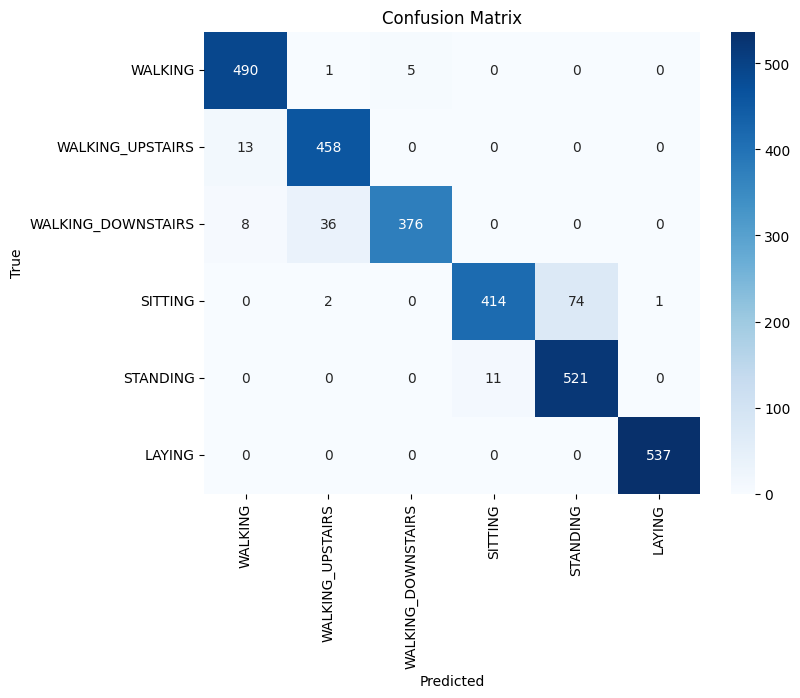


Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.96      0.99      0.97       496
  WALKING_UPSTAIRS       0.92      0.97      0.95       471
WALKING_DOWNSTAIRS       0.99      0.90      0.94       420
           SITTING       0.97      0.84      0.90       491
          STANDING       0.88      0.98      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



In [16]:
# PART 5: Evaluate Model (Accuracy, Precision, Recall, F1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels['activity'], yticklabels=activity_labels['activity'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=activity_labels['activity'].values))


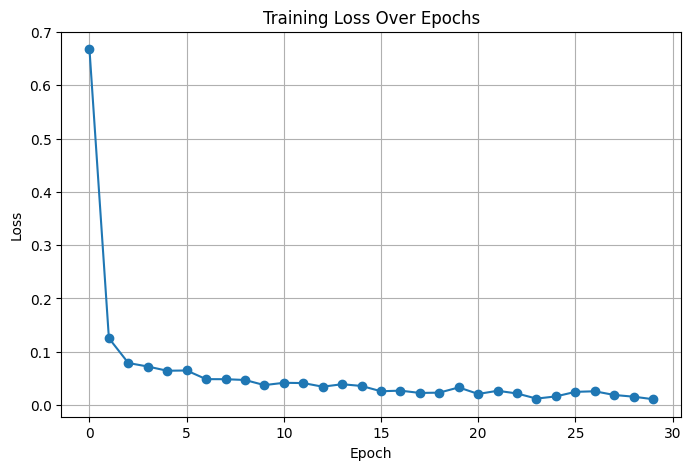

In [17]:
# Plot training loss curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


# **Raw Inertial Signals**

In [18]:
# PART 7: Load Raw Inertial Signal Data

import numpy as np

def load_inertial_signals(folder_path, subset):
    signal_types = ['body_acc_x', 'body_acc_y', 'body_acc_z',
                    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
                    'total_acc_x', 'total_acc_y', 'total_acc_z']
    signals_data = []

    for signal in signal_types:
        file_path = os.path.join(folder_path, subset, 'Inertial Signals', signal + f'_{subset}.txt')
        data = np.loadtxt(file_path)
        signals_data.append(data)

    # Stack signals along the last dimension (features axis)
    signals_data = np.stack(signals_data, axis=-1)  # shape: (samples, 128, 9)
    return signals_data

# Load train and test raw signals
folder = '/content/UCI HAR Dataset'
X_train_raw = load_inertial_signals(folder, 'train')
X_test_raw = load_inertial_signals(folder, 'test')

# Load labels again
y_train_raw = np.loadtxt(os.path.join(folder, 'train', 'y_train.txt')).astype(int) - 1
y_test_raw = np.loadtxt(os.path.join(folder, 'test', 'y_test.txt')).astype(int) - 1

print(f"✅ Loaded raw signals: X_train_raw shape = {X_train_raw.shape}, X_test_raw shape = {X_test_raw.shape}")


✅ Loaded raw signals: X_train_raw shape = (7352, 128, 9), X_test_raw shape = (2947, 128, 9)


In [19]:
# Create Dataset and DataLoader for Raw Inertial Signals

class HAR_InertialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_raw = HAR_InertialDataset(X_train_raw, y_train_raw)
test_dataset_raw = HAR_InertialDataset(X_test_raw, y_test_raw)

train_loader_raw = DataLoader(train_dataset_raw, batch_size=64, shuffle=True)
test_loader_raw = DataLoader(test_dataset_raw, batch_size=64, shuffle=False)


In [20]:
# Build a New LSTM Model for Raw Signals

class RawSignalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RawSignalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = hn[-1]
        out = self.fc(out)
        return out

input_size = 9  # raw sensor channels
hidden_size = 64
num_classes = 6

model_raw = RawSignalLSTM(input_size, hidden_size, num_classes).to(device)


In [21]:

# Train the New Model on Raw Inertial Signals

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_raw.parameters(), lr=0.001)

num_epochs = 30
train_losses_raw = []

for epoch in range(num_epochs):
    model_raw.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader_raw:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model_raw(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader_raw)
    train_losses_raw.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/30, Loss: 1.4061
Epoch 2/30, Loss: 1.0714
Epoch 3/30, Loss: 0.8381
Epoch 4/30, Loss: 0.7479
Epoch 5/30, Loss: 0.6937
Epoch 6/30, Loss: 0.9029
Epoch 7/30, Loss: 0.7217
Epoch 8/30, Loss: 0.7343
Epoch 9/30, Loss: 0.6770
Epoch 10/30, Loss: 0.6545
Epoch 11/30, Loss: 0.6457
Epoch 12/30, Loss: 0.5995
Epoch 13/30, Loss: 0.5499
Epoch 14/30, Loss: 0.4988
Epoch 15/30, Loss: 1.0126
Epoch 16/30, Loss: 0.8302
Epoch 17/30, Loss: 0.6457
Epoch 18/30, Loss: 0.5005
Epoch 19/30, Loss: 0.4388
Epoch 20/30, Loss: 0.3525
Epoch 21/30, Loss: 0.3127
Epoch 22/30, Loss: 0.2999
Epoch 23/30, Loss: 0.3114
Epoch 24/30, Loss: 0.2671
Epoch 25/30, Loss: 0.2373
Epoch 26/30, Loss: 0.2977
Epoch 27/30, Loss: 0.2296
Epoch 28/30, Loss: 0.1984
Epoch 29/30, Loss: 0.1894
Epoch 30/30, Loss: 0.1621



✅ Test Accuracy on Raw Signals: 87.04%


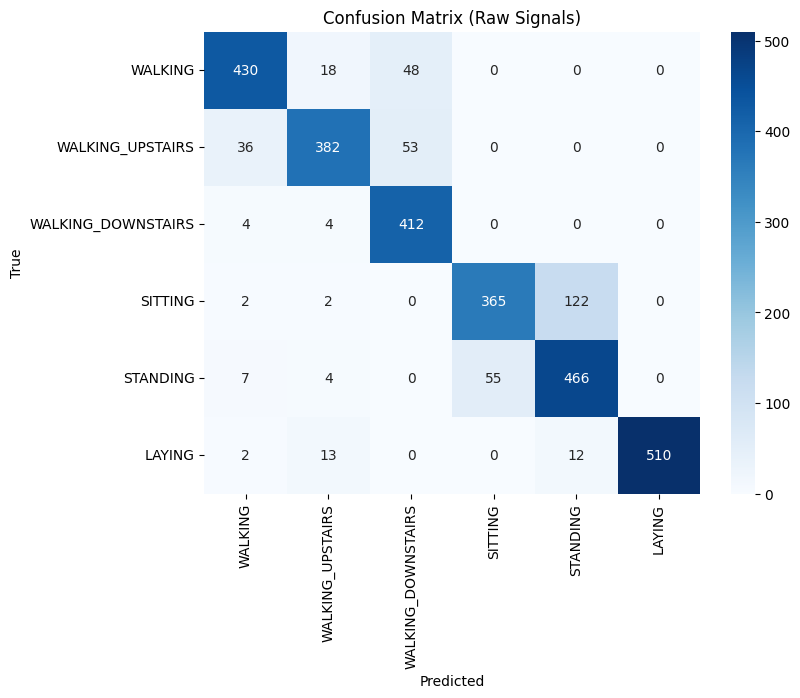


Classification Report (Raw Signals):
                    precision    recall  f1-score   support

           WALKING       0.89      0.87      0.88       496
  WALKING_UPSTAIRS       0.90      0.81      0.85       471
WALKING_DOWNSTAIRS       0.80      0.98      0.88       420
           SITTING       0.87      0.74      0.80       491
          STANDING       0.78      0.88      0.82       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.87      2947
         macro avg       0.87      0.87      0.87      2947
      weighted avg       0.88      0.87      0.87      2947



In [22]:
# Evaluate the New Model

model_raw.eval()
y_true_raw = []
y_pred_raw = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_raw:
        X_batch = X_batch.to(device)
        outputs = model_raw(X_batch)
        _, preds = torch.max(outputs, 1)
        y_true_raw.extend(y_batch.numpy())
        y_pred_raw.extend(preds.cpu().numpy())

# Accuracy
acc_raw = accuracy_score(y_true_raw, y_pred_raw)
print(f"\n✅ Test Accuracy on Raw Signals: {acc_raw*100:.2f}%")

# Confusion Matrix
cm_raw = confusion_matrix(y_true_raw, y_pred_raw)
plt.figure(figsize=(8,6))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Blues", xticklabels=activity_labels['activity'], yticklabels=activity_labels['activity'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Raw Signals)")
plt.show()

# Classification Report
print("\nClassification Report (Raw Signals):")
print(classification_report(y_true_raw, y_pred_raw, target_names=activity_labels['activity'].values))


# **Comparison Between the 2 Models**

In [23]:
# ====================================================
# Comparison between Model 1 and Model 2
# ====================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# 2. Evaluate both models
y_true_features, y_pred_features = evaluate_model(model, test_loader, device)
y_true_raw, y_pred_raw = evaluate_model(model_raw, test_loader_raw, device)

# 3. Compute metrics
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=activity_labels['activity'].values, output_dict=True)
    return acc, report

acc_features, report_features = compute_metrics(y_true_features, y_pred_features)
acc_raw, report_raw = compute_metrics(y_true_raw, y_pred_raw)

# 4. Print metrics comparison
print("🔵 Model 1 (Extracted Features) Results:")
print(f"Accuracy: {acc_features*100:.2f}%")
print(classification_report(y_true_features, y_pred_features, target_names=activity_labels['activity'].values))

print("\n🟢 Model 2 (Raw Inertial Signals) Results:")
print(f"Accuracy: {acc_raw*100:.2f}%")
print(classification_report(y_true_raw, y_pred_raw, target_names=activity_labels['activity'].values))


🔵 Model 1 (Extracted Features) Results:
Accuracy: 94.88%
                    precision    recall  f1-score   support

           WALKING       0.96      0.99      0.97       496
  WALKING_UPSTAIRS       0.92      0.97      0.95       471
WALKING_DOWNSTAIRS       0.99      0.90      0.94       420
           SITTING       0.97      0.84      0.90       491
          STANDING       0.88      0.98      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947


🟢 Model 2 (Raw Inertial Signals) Results:
Accuracy: 87.04%
                    precision    recall  f1-score   support

           WALKING       0.89      0.87      0.88       496
  WALKING_UPSTAIRS       0.90      0.81      0.85       471
WALKING_DOWNSTAIRS       0.80      0.98      0.88       420
           SITTING       0.87      0.74

In [25]:
import pandas as pd

# Build a summary table
comparison_table = pd.DataFrame({
    "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score"],
    "Model 1: Extracted Features (561 features)": [
        acc_features * 100,
        report_features['macro avg']['precision'] * 100,
        report_features['macro avg']['recall'] * 100,
        report_features['macro avg']['f1-score'] * 100
    ],
    "Model 2: Raw Inertial Signals (128x9)": [
        acc_raw * 100,
        report_raw['macro avg']['precision'] * 100,
        report_raw['macro avg']['recall'] * 100,
        report_raw['macro avg']['f1-score'] * 100
    ]
})

# Round values nicely
comparison_table = comparison_table.round(2)

# Show the table
comparison_table


,Metric,Model 1: Extracted Features (561 features),Model 2: Raw Inertial Signals (128x9)
0,Accuracy,94.88,87.04
1,Macro Precision,95.25,87.43
2,Macro Recall,94.63,87.13
3,Macro F1-Score,94.76,86.95


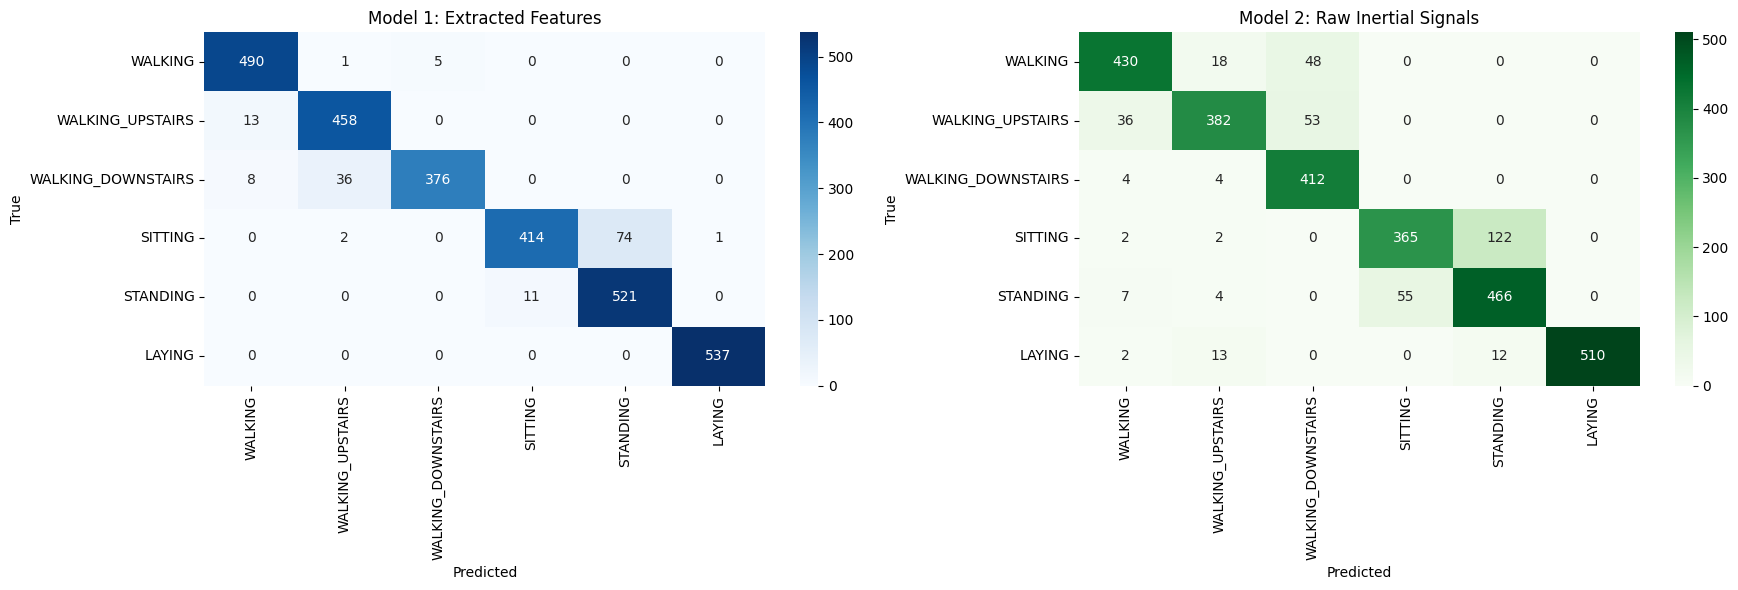

In [24]:
# 5. Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Model 1: Features
cm_features = confusion_matrix(y_true_features, y_pred_features)
sns.heatmap(cm_features, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=activity_labels['activity'], yticklabels=activity_labels['activity'])
axes[0].set_title('Model 1: Extracted Features')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Model 2: Raw Signals
cm_raw = confusion_matrix(y_true_raw, y_pred_raw)
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Greens", ax=axes[1],
            xticklabels=activity_labels['activity'], yticklabels=activity_labels['activity'])
axes[1].set_title('Model 2: Raw Inertial Signals')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()
